In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from datetime import datetime

In [2]:
def explore_csv_data(file_path):
    """
    Explore and display detailed information about a CSV file.
    
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: The loaded DataFrame
    """
    print(f"Exploring CSV file: {file_path}")
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None
    
    # Read the CSV file
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded CSV with shape: {df.shape}")
    except Exception as e:
        print(f"Error reading CSV: {str(e)}")
        return None
    
    # Basic DataFrame information
    print("\n=== BASIC INFORMATION ===")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Column names and data types
    print("\n=== COLUMNS AND DATA TYPES ===")
    for col, dtype in zip(df.columns, df.dtypes):
        print(f"{col}: {dtype}")
    
    # Missing values summary
    print("\n=== MISSING VALUES ===")
    missing = df.isna().sum()
    missing_percent = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_percent
    })
    print(missing_info[missing_info['Missing Values'] > 0].sort_values('Missing Values', ascending=False))
    
    # Summary statistics for numeric columns
    print("\n=== NUMERIC COLUMNS STATISTICS ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(df[numeric_cols].describe().T)
    else:
        print("No numeric columns found")
    
    # Unique values for categorical columns (showing only for columns with fewer than 20 unique values)
    print("\n=== CATEGORICAL COLUMNS ===")
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        unique_values = df[col].nunique()
        print(f"{col}: {unique_values} unique values")
        
        if unique_values < 20:
            value_counts = df[col].value_counts()
            print(value_counts.head(10))
            if unique_values > 10:
                print("... (showing only top 10)")
        else:
            print("Too many unique values to display")
        print()
    
    # Check for specific columns of interest
    print("\n=== COLUMNS OF INTEREST ===")
    columns_of_interest = ['YearsCode', 'EdLevel', 'DevType', 'OrgSize', 'Country', 'Age',
                          'Gender', 'CompTotal', 'CompFreq', 'Currency', 'LanguageHaveWorkedWith']
    
    for col in columns_of_interest:
        if col in df.columns:
            print(f"\n{col} information:")
            if df[col].dtype == 'object':
                print(f"Top 10 values:")
                print(df[col].value_counts().head(10))
                
                # Check for Vietnam specifically if it's the Country column
                if col == 'Country':
                    vietnam_count = df[df['Country'] == 'Viet Nam'].shape[0]
                    print(f"\nRecords from Vietnam: {vietnam_count}")
            else:
                print(df[col].describe())
        else:
            print(f"{col} not found in the dataset")
    
    return df

In [3]:

def preprocess_salary_data(file_path):
    """
    Preprocess salary data from Stack Overflow survey.
    
    Parameters:
    file_path (str): Path to the CSV file
    display_full (bool): Whether to display the full DataFrame at the end
    
    Returns:
    pandas.DataFrame: Processed DataFrame with filtered and renamed columns, with reset index
    """
    # Read the CSV with all columns
    df_full = pd.read_csv(file_path)
    print(f"Original DataFrame shape: {df_full.shape}")
    print(f"Original columns: {df_full.columns.tolist()}")
    
    # Define column mappings with alternatives
    column_alternatives = {
        'YearsExperience': ['YearsCode', 'YearsCoding', 'CodingExperience', 'YearsCodedJob'],
        'Education': ['EdLevel', 'FormalEducation', 'Education'],
        'JobRole': ['DevType', 'DeveloperType', 'JobRole'],
        'OrgSize': ['OrgSize', 'CompanySize', 'OrganizationSize'],
        'Location': ['Country', 'CountryCode', 'Location'],
        'CompTotal': ['CompTotal', 'Salary', 'AnnualSalary'],
        'CompFreq': ['CompFreq', 'SalaryFrequency', 'SalaryType'],
        'Currency': ['CurrencyDesc', 'Currency', 'CurrencyDesc'],
        'LanguageHaveWorkedWith': ['HaveWorkedLanguage', 'LanguageWorkedWith']
    }
    
    # Create a new DataFrame to store the processed data
    salary_df = pd.DataFrame()
    
    # Process each target column
    for target_col, source_cols in column_alternatives.items():
        found = False
        for source_col in source_cols:
            if source_col in df_full.columns:
                salary_df[target_col] = df_full[source_col].copy()
                print(f"Using '{source_col}' for '{target_col}'")
                found = True
                break
        
        if not found:
            print(f"Warning: No column found for '{target_col}'. Using 'NOT PROVIDED'")
            if target_col in ['YearsExperience', 'CompTotal']:
                salary_df[target_col] = 0
            else:
                salary_df[target_col] = "NOT PROVIDED"
    
    # Handle NonDeveloperType if it exists and add to JobRole
    if 'NonDeveloperType' in df_full.columns and 'JobRole' in salary_df.columns:
        print("Found 'NonDeveloperType' column, merging with JobRole...")
        
        # For rows where JobRole is NA or empty but NonDeveloperType has a value
        mask = ((salary_df['JobRole'].isna()) | (salary_df['JobRole'] == '')) & (~df_full['NonDeveloperType'].isna())
        salary_df.loc[mask, 'JobRole'] = df_full.loc[mask, 'NonDeveloperType']
        
        print(f"Added {mask.sum()} values from NonDeveloperType to JobRole")
    
    # Copy other required columns directly
    other_cols = ['Age', 'Gender']
    for col in other_cols:
        if col in df_full.columns:
            salary_df[col] = df_full[col].copy()
        else:
            print(f"Warning: Column '{col}' not found. Using 'NOT PROVIDED'")
            salary_df[col] = "NOT PROVIDED"
    
    print(f"After selecting and mapping columns: {salary_df.shape}")
    
    # Handle YearsExperience as string
    print("\nHandling YearsExperience as string...")
    # First, check the unique values
    print("Unique values in YearsExperience:")
    unique_years = salary_df['YearsExperience'].unique()
    print(unique_years[:20] if len(unique_years) > 20 else unique_years)  # Show first 20 if there are many
    
    # Fill NaN values with "Not provided"
    salary_df['YearsExperience'] = salary_df['YearsExperience'].fillna("Not provided")
    
    # Convert any numeric values to strings to ensure consistent type
    salary_df['YearsExperience'] = salary_df['YearsExperience'].astype(str)
    
    print("YearsExperience data type after handling:", salary_df['YearsExperience'].dtype)
    
    # Define all possible variations of Vietnam
    vietnam_variations = ['Viet Nam', 'Vietnam', 'VietNam', 'Viet nam']

    # Filter for Vietnam only (checking all variations)
    vietnam_mask = salary_df['Location'].isin(vietnam_variations)
    vietnam_count = vietnam_mask.sum()
    print(f"\nRecords from Vietnam (all variations): {vietnam_count}")

    salary_df = salary_df[vietnam_mask]
    print(f"After filtering for Vietnam: {salary_df.shape}")

    # # Drop rows where OrgSize is NaN
    # na_count_orgsize_before = salary_df['OrgSize'].isna().sum()
    # print(f"NaN values in OrgSize before dropping: {na_count_orgsize_before}")
    
    # salary_df = salary_df.dropna(subset=['OrgSize'])
    # print(f"After dropping NaN in OrgSize: {salary_df.shape}")
    
    # Drop rows where CompTotal is NaN
    na_count_comptotal_before = salary_df['CompTotal'].isna().sum()
    print(f"NaN values in CompTotal before dropping: {na_count_comptotal_before}")
    
    salary_df = salary_df.dropna(subset=['CompTotal'])
    print(f"After dropping NaN in CompTotal: {salary_df.shape}")
    
    # Filter out unwanted OrgSize values
    print("\nOrgSize value counts:")
    print(salary_df['OrgSize'].value_counts().to_string())
    
    org_size_to_exclude = [
        '2 to 9 employees', 
        "Just me - I am a freelancer, sole proprietor, etc.", 
        "Fewer than 10 employees"
    ]
    salary_df = salary_df[~salary_df['OrgSize'].isin(org_size_to_exclude)]
    print(f"After filtering OrgSize: {salary_df.shape}")
    
    # Filter out NA in JobRole
    print("\nJobRole value counts:")
    print(salary_df['JobRole'].value_counts().to_string())
    
    na_count_jobrole = salary_df['JobRole'].isna().sum()
    print(f"NA values in JobRole: {na_count_jobrole}")
    
    salary_df = salary_df[salary_df['JobRole'].notna()]
    print(f"After filtering JobRole NAs: {salary_df.shape}")
    
    # Reset index
    salary_df = salary_df.reset_index(drop=True)

    return salary_df

In [4]:
def analyze_preprocessed_data(df, show_plots=True):
    """
    Analyze the preprocessed DataFrame in detail.
    
    Parameters:
    df (pandas.DataFrame): The preprocessed DataFrame
    show_plots (bool): Whether to display visualizations
    
    Returns:
    dict: Dictionary containing analysis results
    """
    results = {}
    
    print("=== PREPROCESSED DATA ANALYSIS ===")
    print(f"DataFrame shape: {df.shape} (rows, columns)")
    
    # Basic information
    print("\n=== BASIC INFORMATION ===")
    print(f"Number of records: {len(df)}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Column information
    print("\n=== COLUMNS OVERVIEW ===")
    column_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Non-Null Count': df.count(),
        'Null Count': df.isna().sum(),
        'Null Percentage': (df.isna().sum() / len(df) * 100).round(2),
        'Unique Values': df.nunique()
    })
    display(column_info)
    results['column_info'] = column_info
    
    # Descriptive statistics for numeric columns
    print("\n=== NUMERIC COLUMNS STATISTICS ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        numeric_stats = df[numeric_cols].describe().T
        numeric_stats['CV'] = (numeric_stats['std'] / numeric_stats['mean'] * 100).round(2)  # Coefficient of variation
        display(numeric_stats)
        results['numeric_stats'] = numeric_stats
    else:
        print("No numeric columns found")
    
    # Categorical columns analysis
    print("\n=== CATEGORICAL COLUMNS ANALYSIS ===")
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    cat_analysis = {}
    
    for col in categorical_cols:
        print(f"\n{col}:")
        value_counts = df[col].value_counts()
        value_percent = (df[col].value_counts(normalize=True) * 100).round(2)
        cat_df = pd.DataFrame({
            'Count': value_counts,
            'Percentage': value_percent
        })
        display(cat_df)
        cat_analysis[col] = cat_df
        
        # Plot for categorical columns
        if show_plots and len(value_counts) <= 15:
            plt.figure(figsize=(10, 6))
            sns.countplot(y=col, data=df, order=value_counts.index)
            plt.title(f'Distribution of {col}')
            plt.tight_layout()
            plt.show()
    
    results['categorical_analysis'] = cat_analysis
    
    # Specific analysis for salary-related columns
    print("\n=== SALARY ANALYSIS ===")
    if 'CompTotal' in df.columns:
        # Basic statistics
        print("Compensation Statistics:")
        comp_stats = df['CompTotal'].describe()
        display(comp_stats)
        results['comp_stats'] = comp_stats
        
        # Compensation by currency
        if 'Currency' in df.columns:
            print("\nCompensation by Currency:")
            currency_comp = df.groupby('Currency')['CompTotal'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
            display(currency_comp)
            results['currency_comp'] = currency_comp
        
        # Compensation by frequency
        if 'CompFreq' in df.columns:
            print("\nCompensation by Frequency:")
            freq_comp = df.groupby('CompFreq')['CompTotal'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
            display(freq_comp)
            results['freq_comp'] = freq_comp
        
        # Compensation distribution plot
        if show_plots:
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)
            sns.histplot(df['CompTotal'], kde=True)
            plt.title('Compensation Distribution')
            plt.xlabel('Compensation')
            
            plt.subplot(1, 2, 2)
            sns.boxplot(y=df['CompTotal'])
            plt.title('Compensation Boxplot')
            plt.ylabel('Compensation')
            
            plt.tight_layout()
            plt.show()
    
    # Experience vs Compensation analysis
    if 'YearsExperience' in df.columns and 'CompTotal' in df.columns:
        print("\n=== EXPERIENCE VS COMPENSATION ANALYSIS ===")
        
        # Check if YearsExperience needs conversion from string to numeric
        if df['YearsExperience'].dtype == 'object':
            print("Note: YearsExperience is not numeric. Consider converting it for better analysis.")
        
        # If it's numeric, show correlation
        if df['YearsExperience'].dtype != 'object':
            corr = df[['YearsExperience', 'CompTotal']].corr().iloc[0, 1]
            print(f"Correlation between YearsExperience and CompTotal: {corr:.4f}")
            results['exp_comp_corr'] = corr
            
            if show_plots:
                plt.figure(figsize=(10, 6))
                sns.scatterplot(x='YearsExperience', y='CompTotal', data=df)
                plt.title('Compensation vs Years of Experience')
                plt.xlabel('Years of Experience')
                plt.ylabel('Compensation')
                plt.tight_layout()
                plt.show()
    
    # Job Role analysis
    if 'JobRole' in df.columns:
        print("\n=== JOB ROLE ANALYSIS ===")
        
        # Count of each job role
        job_counts = df['JobRole'].value_counts()
        print("Job Role Distribution:")
        display(job_counts)
        results['job_counts'] = job_counts
        
        # Compensation by job role
        if 'CompTotal' in df.columns:
            print("\nCompensation by Job Role:")
            job_comp = df.groupby('JobRole')['CompTotal'].agg(['count', 'mean', 'median', 'std'])
            job_comp = job_comp.sort_values('median', ascending=False)
            display(job_comp)
            results['job_comp'] = job_comp
            
            if show_plots and len(job_counts) <= 15:
                plt.figure(figsize=(12, 8))
                sns.boxplot(y='JobRole', x='CompTotal', data=df, order=job_comp.index)
                plt.title('Compensation by Job Role')
                plt.xlabel('Compensation')
                plt.tight_layout()
                plt.show()
    
    # Organization size analysis
    if 'OrgSize' in df.columns:
        print("\n=== ORGANIZATION SIZE ANALYSIS ===")
        org_counts = df['OrgSize'].value_counts()
        print("Organization Size Distribution:")
        display(org_counts)
        results['org_counts'] = org_counts
        
        if 'CompTotal' in df.columns:
            print("\nCompensation by Organization Size:")
            org_comp = df.groupby('OrgSize')['CompTotal'].agg(['count', 'mean', 'median', 'std'])
            display(org_comp)
            results['org_comp'] = org_comp
            
            if show_plots:
                plt.figure(figsize=(12, 6))
                sns.boxplot(x='OrgSize', y='CompTotal', data=df)
                plt.title('Compensation by Organization Size')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
    
    # Programming languages analysis
    if 'LanguageHaveWorkedWith' in df.columns:
        print("\n=== PROGRAMMING LANGUAGES ANALYSIS ===")
        
        # Split the languages and count occurrences
        all_languages = df['LanguageHaveWorkedWith'].str.split(';').explode()
        lang_counts = all_languages.value_counts()
        
        print("Top Programming Languages:")
        display(lang_counts.head(10))
        results['lang_counts'] = lang_counts
        
        if show_plots:
            plt.figure(figsize=(12, 6))
            sns.barplot(x=lang_counts.head(10).values, y=lang_counts.head(10).index)
            plt.title('Top 10 Programming Languages')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.show()
    
    return results

In [5]:
file_path_21 = '../training_data/survey_results_public_21.csv'

In [6]:
salary_details_21 = explore_csv_data(file_path_21)
salary_details_21.head(5)

Exploring CSV file: ../training_data/survey_results_public_21.csv
Successfully loaded CSV with shape: (83439, 48)

=== BASIC INFORMATION ===
Number of rows: 83439
Number of columns: 48
Memory usage: 30.56 MB

=== COLUMNS AND DATA TYPES ===
ResponseId: int64
MainBranch: object
Employment: object
Country: object
US_State: object
UK_Country: object
EdLevel: object
Age1stCode: object
LearnCode: object
YearsCode: object
YearsCodePro: object
DevType: object
OrgSize: object
Currency: object
CompTotal: float64
CompFreq: object
LanguageHaveWorkedWith: object
LanguageWantToWorkWith: object
DatabaseHaveWorkedWith: object
DatabaseWantToWorkWith: object
PlatformHaveWorkedWith: object
PlatformWantToWorkWith: object
WebframeHaveWorkedWith: object
WebframeWantToWorkWith: object
MiscTechHaveWorkedWith: object
MiscTechWantToWorkWith: object
ToolsTechHaveWorkedWith: object
ToolsTechWantToWorkWith: object
NEWCollabToolsHaveWorkedWith: object
NEWCollabToolsWantToWorkWith: object
OpSys: object
NEWStuck: obj

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN


In [7]:
# Process the 2021 survey data
salary_df_21 = preprocess_salary_data(file_path_21)
salary_df_21.head(5)

Original DataFrame shape: (83439, 48)
Original columns: ['ResponseId', 'MainBranch', 'Employment', 'Country', 'US_State', 'UK_Country', 'EdLevel', 'Age1stCode', 'LearnCode', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'Currency', 'CompTotal', 'CompFreq', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith', 'PlatformWantToWorkWith', 'WebframeHaveWorkedWith', 'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSys', 'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq', 'SOComm', 'NEWOtherComms', 'Age', 'Gender', 'Trans', 'Sexuality', 'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength', 'SurveyEase', 'ConvertedCompYearly']
Using 'YearsCode' for 'YearsExperience'
Using 'EdLevel' for 'Education'
Using 'DevType' for 'JobRole'
Using 'OrgSize' 

,YearsExperience,Education,JobRole,OrgSize,Location,CompTotal,CompFreq,Currency,LanguageHaveWorkedWith,Age,Gender
0,Not provided,Some college/university study without earning ...,"Developer, back-end;Data or business analyst","1,000 to 4,999 employees",Viet Nam,47000000.0,Monthly,VND\tVietnamese dong,NOT PROVIDED,25-34 years old,Man
1,4,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Developer, front-end",20 to 99 employees,Viet Nam,35000000.0,Monthly,VND\tVietnamese dong,NOT PROVIDED,25-34 years old,Man
2,7,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Developer, mobile","10,000 or more employees",Viet Nam,70000000.0,Monthly,VND\tVietnamese dong,NOT PROVIDED,25-34 years old,Man
3,10,Some college/university study without earning ...,"Developer, full-stack",20 to 99 employees,Viet Nam,10000000.0,Monthly,VND\tVietnamese dong,NOT PROVIDED,25-34 years old,Prefer not to say
4,13,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Developer, full-stack;DevOps specialist","1,000 to 4,999 employees",Viet Nam,12000000.0,Monthly,VND\tVietnamese dong,NOT PROVIDED,18-24 years old,Man


=== PREPROCESSED DATA ANALYSIS ===
DataFrame shape: (128, 11) (rows, columns)

=== BASIC INFORMATION ===
Number of records: 128
Memory usage: 0.01 MB

=== COLUMNS OVERVIEW ===


,Data Type,Non-Null Count,Null Count,Null Percentage,Unique Values
YearsExperience,object,128,0,0.00,20
Education,object,128,0,0.00,7
JobRole,object,128,0,0.00,68
OrgSize,object,127,1,0.78,8
Location,object,128,0,0.00,1
CompTotal,float64,128,0,0.00,68
CompFreq,object,127,1,0.78,3
Currency,object,128,0,0.00,3
LanguageHaveWorkedWith,object,128,0,0.00,1
Age,object,128,0,0.00,3



=== NUMERIC COLUMNS STATISTICS ===


,count,mean,std,min,25%,50%,75%,max,CV
CompTotal,128.0,6.124182e+07,1.785277e+08,0.0,10000000.0,20000000.0,35000000.0,1.500000e+09,291.51



=== CATEGORICAL COLUMNS ANALYSIS ===

YearsExperience:


,Count,Percentage
YearsExperience,,
4,16,12.50
5,16,12.50
10,15,11.72
7,13,10.16
6,12,9.38
3,9,7.03
8,9,7.03
13,6,4.69
11,4,3.12



Education:


,Count,Percentage
Education,,
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",82,64.06
Some college/university study without earning a degree,27,21.09
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",8,6.25
"Associate degree (A.A., A.S., etc.)",7,5.47
Primary/elementary school,2,1.56
"Professional degree (JD, MD, etc.)",1,0.78
"Other doctoral degree (Ph.D., Ed.D., etc.)",1,0.78


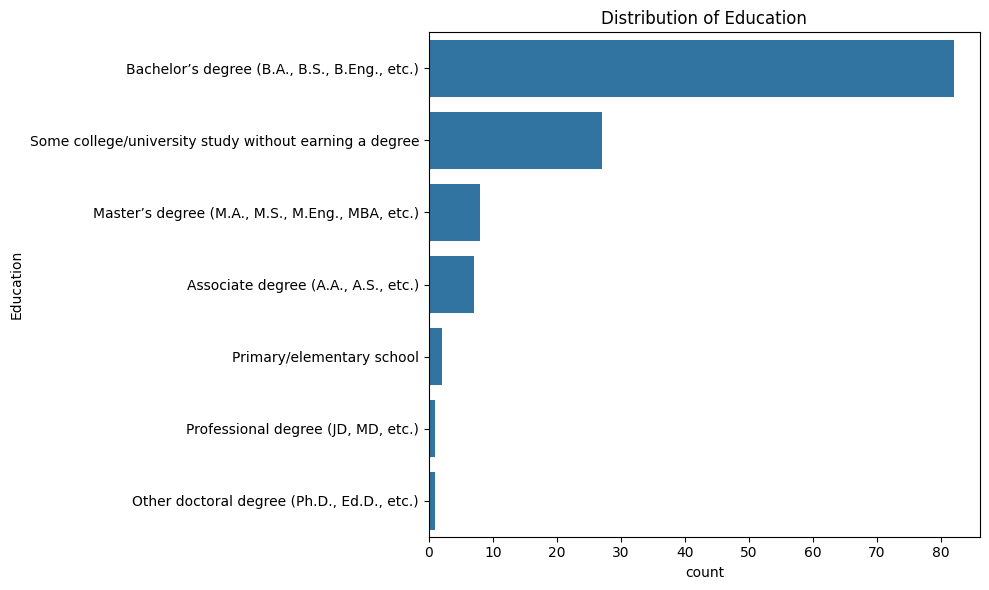


JobRole:


,Count,Percentage
JobRole,,
"Developer, full-stack",15,11.72
"Developer, mobile",11,8.59
"Developer, back-end",11,8.59
"Developer, front-end",9,7.03
"Developer, full-stack;Developer, back-end",5,3.91
...,...,...
"Developer, desktop or enterprise applications;Developer, full-stack;Developer, back-end;Database administrator;Data or business analyst;Designer;System administrator",1,0.78
"DevOps specialist;Engineer, site reliability",1,0.78
"Developer, desktop or enterprise applications;Developer, full-stack;Developer, back-end;Product manager",1,0.78



OrgSize:


,Count,Percentage
OrgSize,,
20 to 99 employees,48,37.80
100 to 499 employees,31,24.41
"1,000 to 4,999 employees",14,11.02
10 to 19 employees,11,8.66
500 to 999 employees,8,6.30
"10,000 or more employees",7,5.51
"5,000 to 9,999 employees",5,3.94
I don’t know,3,2.36


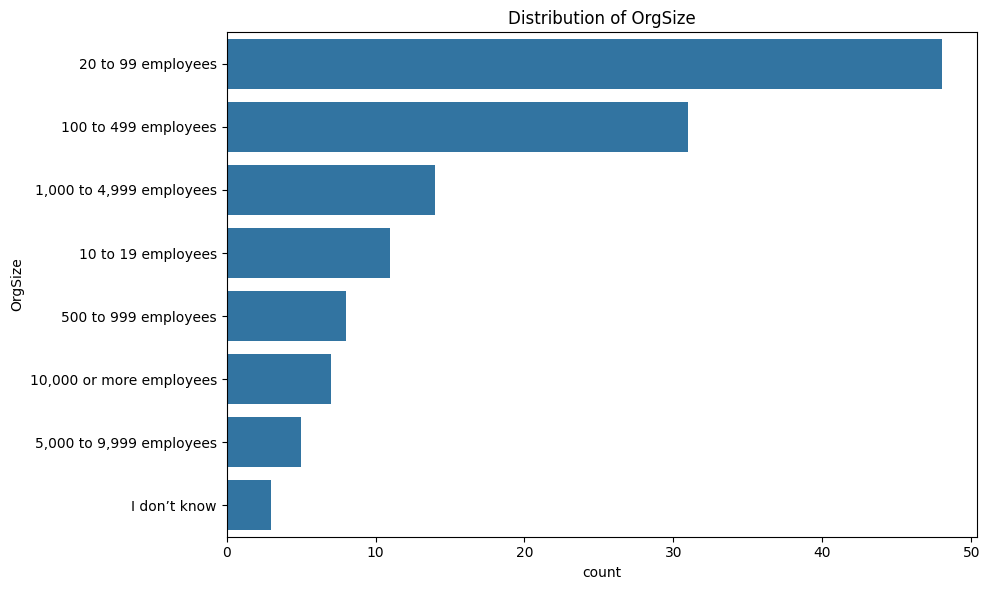


Location:


,Count,Percentage
Location,,
Viet Nam,128,100.0


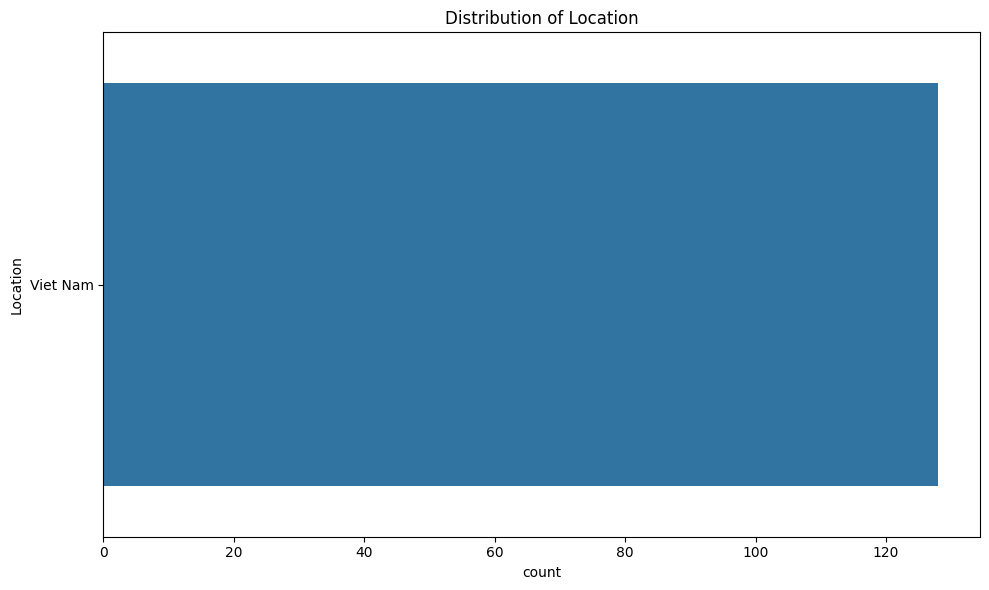


CompFreq:


,Count,Percentage
CompFreq,,
Monthly,117,92.13
Yearly,8,6.30
Weekly,2,1.57


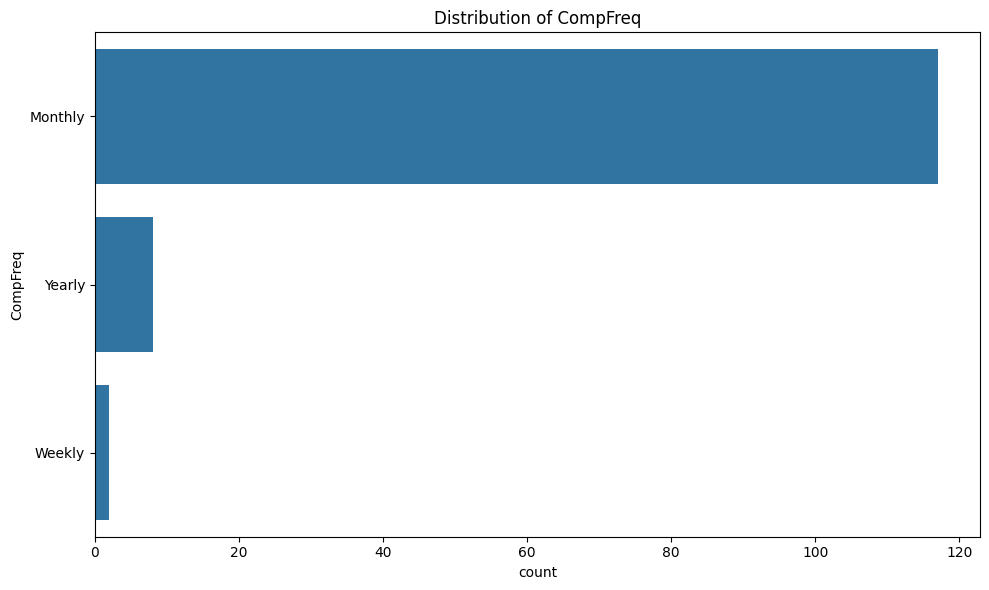


Currency:


,Count,Percentage
Currency,,
VND\tVietnamese dong,115,89.84
USD\tUnited States dollar,12,9.38
EUR European Euro,1,0.78


C:\Users\a5155733\AppData\Local\Temp\ipykernel_27388\1639519653.py:66: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\a5155733\MCS\IS\Assignment\RF-VN-Employee-Salary-Predictor\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


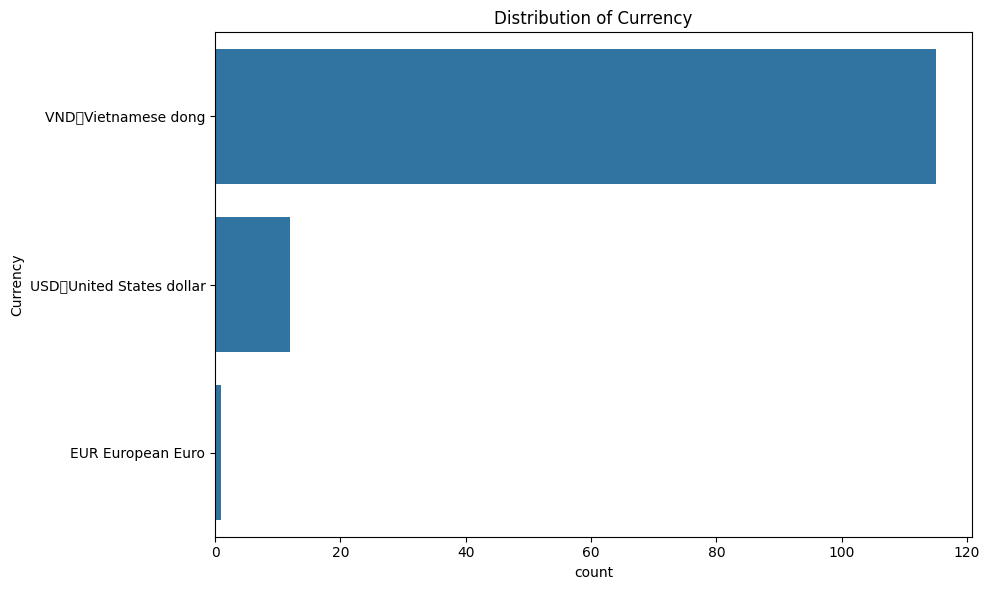


LanguageHaveWorkedWith:


,Count,Percentage
LanguageHaveWorkedWith,,
NOT PROVIDED,128,100.0


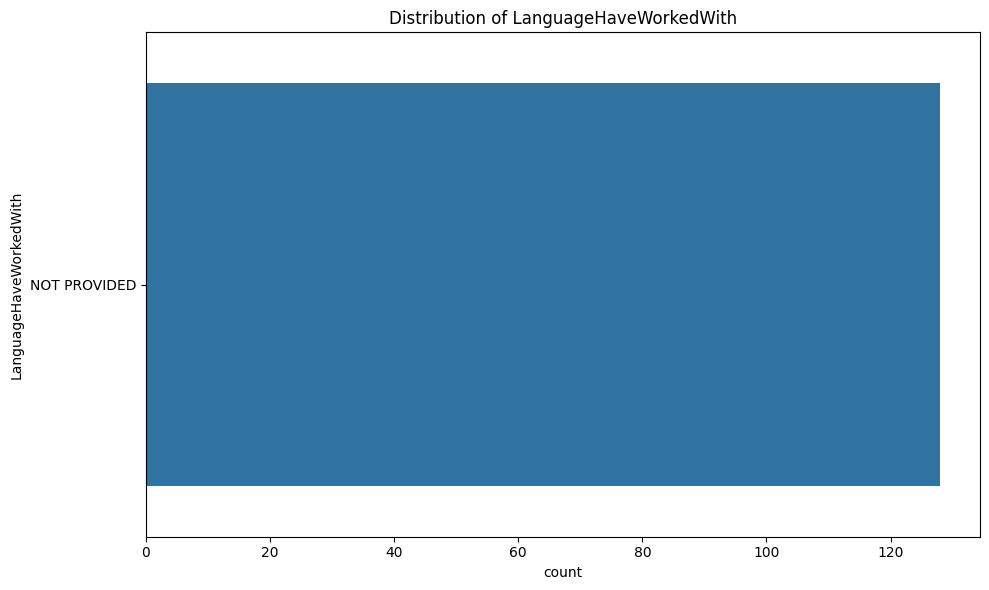


Age:


,Count,Percentage
Age,,
25-34 years old,77,60.16
18-24 years old,46,35.94
35-44 years old,5,3.91


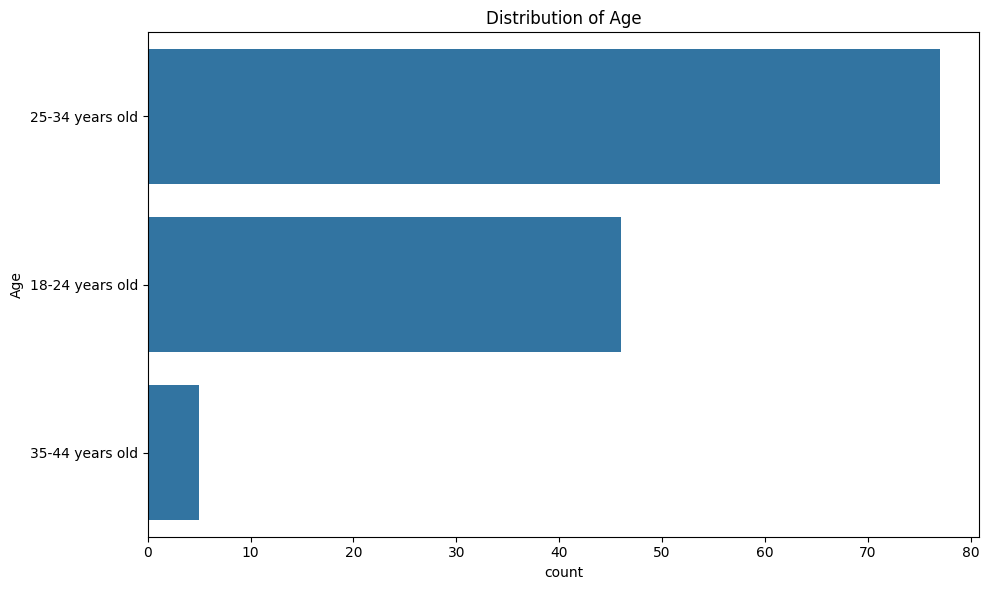


Gender:


,Count,Percentage
Gender,,
Man,124,96.88
Woman,3,2.34
Prefer not to say,1,0.78


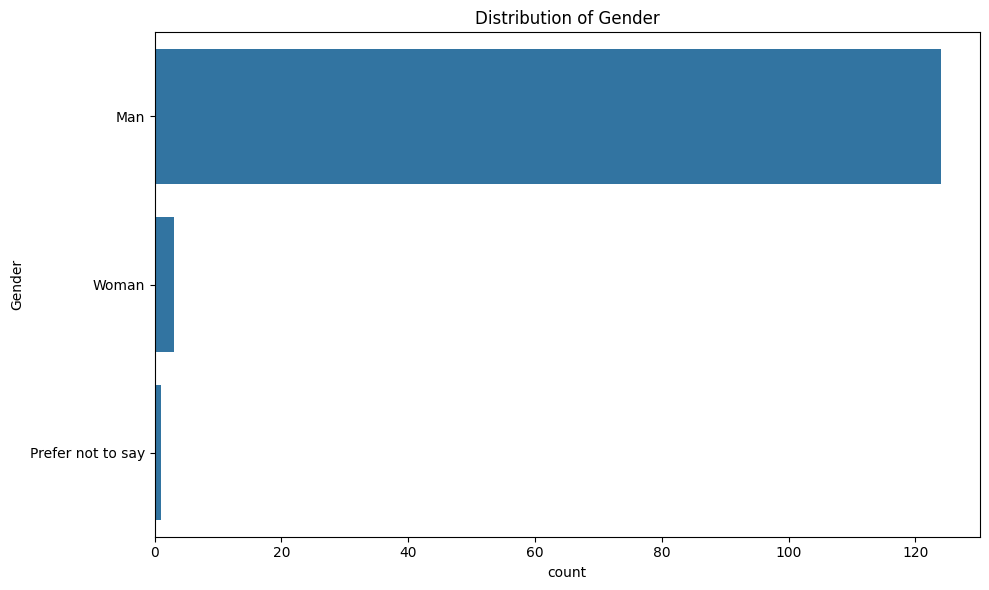


=== SALARY ANALYSIS ===
Compensation Statistics:


count    1.280000e+02
mean     6.124182e+07
std      1.785277e+08
min      0.000000e+00
25%      1.000000e+07
50%      2.000000e+07
75%      3.500000e+07
max      1.500000e+09
Name: CompTotal, dtype: float64


Compensation by Currency:


,count,mean,median,std,min,max
Currency,,,,,,
EUR European Euro,1,2.300000e+03,2300.0,NaN,2300.0,2.300000e+03
USD\tUnited States dollar,12,1.497500e+03,1450.0,9.349198e+02,0.0,3.500000e+03
VND\tVietnamese dong,115,6.816463e+07,20000000.0,1.871648e+08,20.0,1.500000e+09



Compensation by Frequency:


,count,mean,median,std,min,max
CompFreq,,,,,,
Monthly,117,2.814274e+07,20000000.0,4.897586e+07,0.0,5.000000e+08
Weekly,2,6.254000e+05,625400.0,8.833178e+05,800.0,1.250000e+06
Yearly,8,5.612501e+08,415000000.0,4.831277e+08,1000.0,1.500000e+09


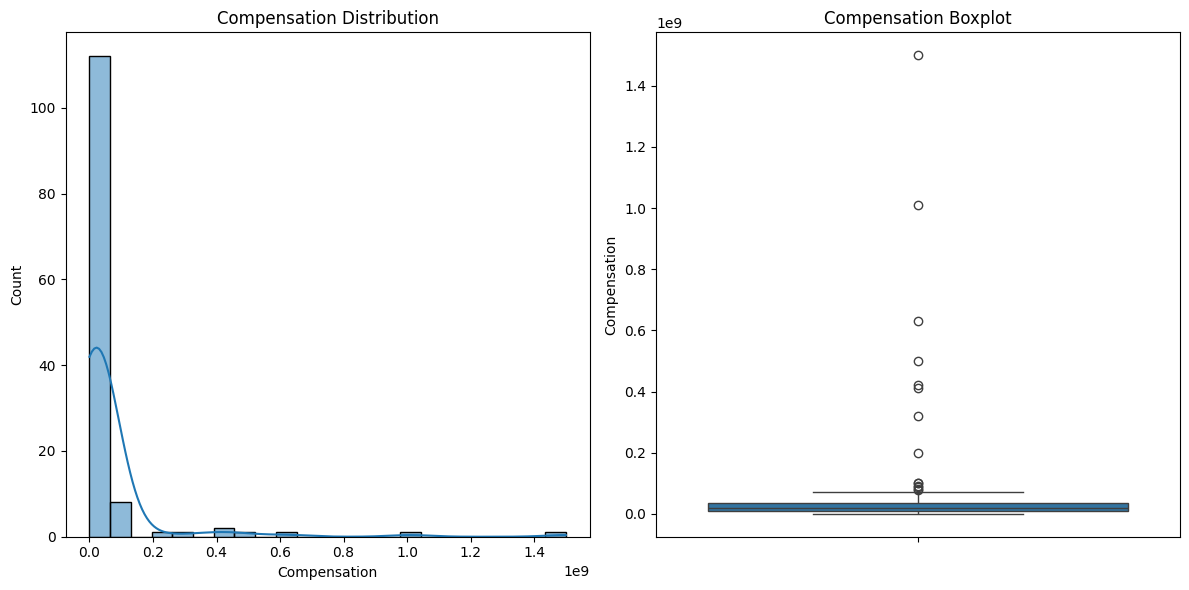


=== EXPERIENCE VS COMPENSATION ANALYSIS ===
Note: YearsExperience is not numeric. Consider converting it for better analysis.

=== JOB ROLE ANALYSIS ===
Job Role Distribution:


JobRole
Developer, full-stack                                                                                                                                                                                                                  15
Developer, mobile                                                                                                                                                                                                                      11
Developer, back-end                                                                                                                                                                                                                    11
Developer, front-end                                                                                                                                                                                                                    9
Developer, full-stack;Developer, back-end               


Compensation by Job Role:


,count,mean,median,std
JobRole,,,,
"Developer, full-stack;Engineering manager",1,1.500000e+09,1.500000e+09,NaN
"Developer, desktop or enterprise applications;Developer, embedded applications or devices",1,1.010000e+09,1.010000e+09,NaN
"Developer, front-end;Developer, desktop or enterprise applications;Developer, full-stack;Developer, back-end;Academic researcher;Developer, embedded applications or devices;Data or business analyst;Designer;System administrator",1,5.000000e+08,5.000000e+08,NaN
"Developer, desktop or enterprise applications;Developer, full-stack;Developer, back-end;Product manager",1,4.200000e+08,4.200000e+08,NaN
"Developer, desktop or enterprise applications;Developer, full-stack",1,4.100000e+08,4.100000e+08,NaN
...,...,...,...,...
"Developer, mobile;Developer, back-end",1,2.500000e+03,2.500000e+03,NaN
"Developer, back-end;DevOps specialist",1,2.300000e+03,2.300000e+03,NaN
"DevOps specialist;Engineer, site reliability",1,1.900000e+03,1.900000e+03,NaN



=== ORGANIZATION SIZE ANALYSIS ===
Organization Size Distribution:


OrgSize
20 to 99 employees          48
100 to 499 employees        31
1,000 to 4,999 employees    14
10 to 19 employees          11
500 to 999 employees         8
10,000 or more employees     7
5,000 to 9,999 employees     5
I don’t know                 3
Name: count, dtype: int64


Compensation by Organization Size:


,count,mean,median,std
OrgSize,,,,
"1,000 to 4,999 employees",14,6.429047e+07,16282359.0,1.636385e+08
10 to 19 employees,11,3.297689e+07,14000000.0,5.727544e+07
"10,000 or more employees",7,9.021461e+07,18000000.0,1.820854e+08
100 to 499 employees,31,6.437121e+07,20000000.0,1.896699e+08
20 to 99 employees,48,3.377204e+07,20000000.0,6.189971e+07
"5,000 to 9,999 employees",5,3.784000e+08,27000000.0,6.399651e+08
500 to 999 employees,8,3.925000e+07,31500000.0,2.965396e+07
I don’t know,3,3.802400e+07,29071991.0,2.857191e+07


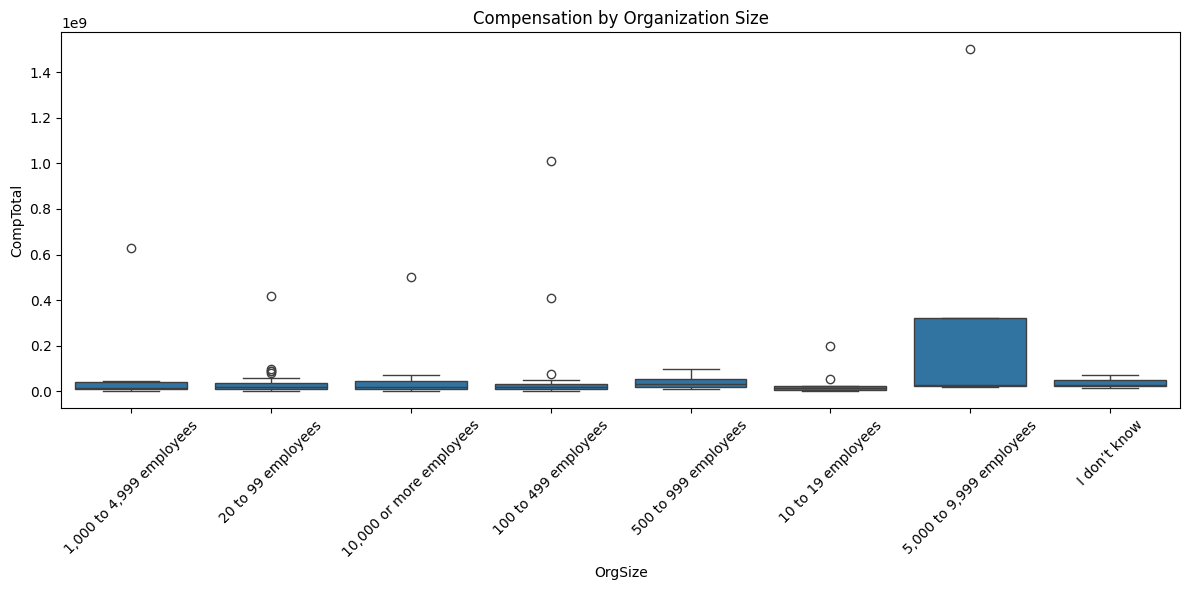


=== PROGRAMMING LANGUAGES ANALYSIS ===
Top Programming Languages:


LanguageHaveWorkedWith
NOT PROVIDED    128
Name: count, dtype: int64

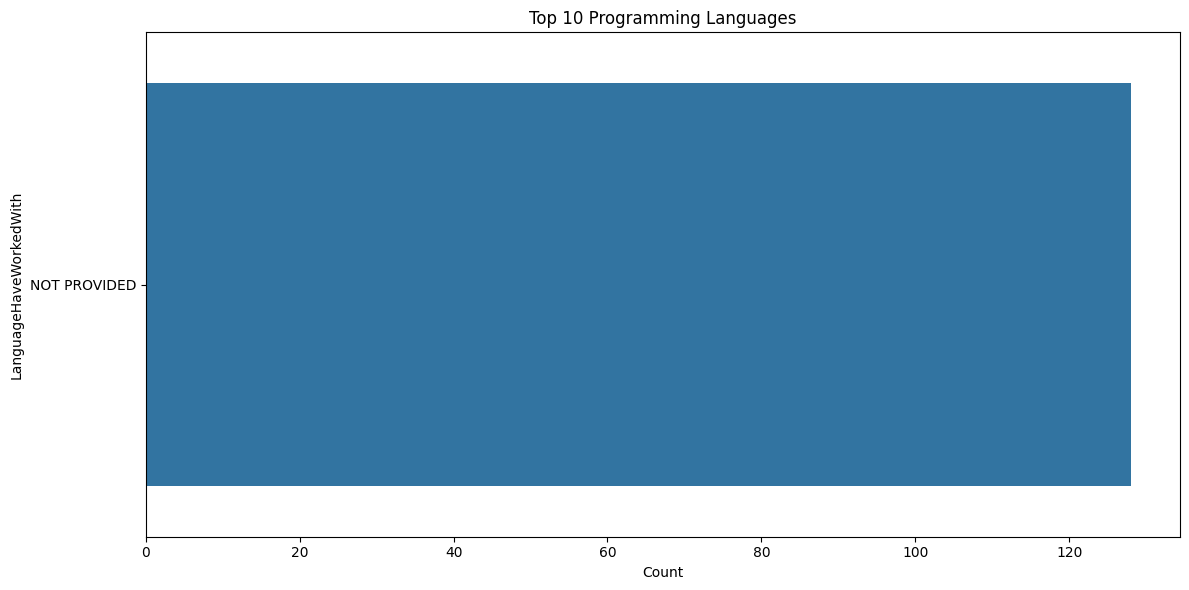

In [8]:
analysis_results = analyze_preprocessed_data(salary_df_21)

In [7]:
def concat_and_save_dataframes(dataframes_list, output_path=None, filename=None):
    """
    Concatenate multiple DataFrames and save the result to a CSV file.
    
    Parameters:
    dataframes_list (list): List of pandas DataFrames to concatenate
    output_path (str): Directory path where the CSV will be saved. If None, uses current directory.
    filename (str): Name of the output CSV file. If None, generates a name with timestamp.
    
    Returns:
    pandas.DataFrame: The concatenated DataFrame
    str: Path to the saved CSV file
    """
    if not dataframes_list:
        print("Error: No DataFrames provided to concatenate.")
        return None, None
    
    # Check if all items are DataFrames
    for i, df in enumerate(dataframes_list):
        if not isinstance(df, pd.DataFrame):
            print(f"Error: Item at index {i} is not a DataFrame.")
            return None, None
    
    print(f"Concatenating {len(dataframes_list)} DataFrames...")
    
    # Print shape of each DataFrame before concatenation
    for i, df in enumerate(dataframes_list):
        print(f"DataFrame {i+1} shape: {df.shape}")
    
    # Concatenate the DataFrames
    concatenated_df = pd.concat(dataframes_list, axis=0, ignore_index=True)
    print(f"Concatenated DataFrame shape: {concatenated_df.shape}")
    
    # Generate filename with timestamp if not provided
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"concatenated_salary_data_{timestamp}.csv"
    
    # Ensure filename has .csv extension
    if not filename.endswith('.csv'):
        filename += '.csv'
    
    # Set default output path if not provided
    if output_path is None:
        output_path = '.'
    
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    
    # Full path to output file
    output_file = os.path.join(output_path, filename)
    
    # Save to CSV
    try:
        concatenated_df.to_csv(output_file, index=False)
        print(f"Successfully saved concatenated DataFrame to: {output_file}")
    except Exception as e:
        print(f"Error saving CSV file: {str(e)}")
        return concatenated_df, None
    
    return concatenated_df, output_file

In [16]:
# Create an empty list to store the processed DataFrames
processed_dfs = []

# Loop through years from 2017 to 2025
for year in range(17, 26):
    # Format the year for the filename (17 -> '17')
    year_str = str(year)
    
    # Construct the file path
    file_path = f'../training_data/survey_results_public_{year_str}.csv'
    
    # Check if the file exists
    if os.path.exists(file_path):
        print(f"\nProcessing data for year 20{year_str}...")
        try:
            # Process the data
            df = preprocess_salary_data(file_path)
            
            # Add to the list if processing was successful
            if df is not None and not df.empty:
                processed_dfs.append(df)
                print(f"Successfully processed data for year 20{year_str}, shape: {df.shape}")
            else:
                print(f"Warning: No data available for year 20{year_str} after processing")
        except Exception as e:
            print(f"Error processing data for year 20{year_str}: {str(e)}")
    else:
        print(f"File not found: {file_path}")

# Check if we have any processed DataFrames
if processed_dfs:
    print(f"\nTotal number of DataFrames to concatenate: {len(processed_dfs)}")
    
    # Concatenate and save
    combined_df, saved_path = concat_and_save_dataframes(
        processed_dfs,
        output_path='../processed_data',
        filename='combined_salary_data_2017_2025.csv'
    )
    
    print(f"\nFinal combined DataFrame shape: {combined_df.shape}")
else:
    print("No data to concatenate. Please check the file paths and processing steps.")


Processing data for year 2017...
Original DataFrame shape: (51392, 154)
Original columns: ['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University', 'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote', 'CompanySize', 'CompanyType', 'YearsProgram', 'YearsCodedJob', 'YearsCodedJobPast', 'DeveloperType', 'WebDeveloperType', 'MobileDeveloperType', 'NonDeveloperType', 'CareerSatisfaction', 'JobSatisfaction', 'ExCoderReturn', 'ExCoderNotForMe', 'ExCoderBalance', 'ExCoder10Years', 'ExCoderBelonged', 'ExCoderSkills', 'ExCoderWillNotCode', 'ExCoderActive', 'PronounceGIF', 'ProblemSolving', 'BuildingThings', 'LearningNewTech', 'BoringDetails', 'JobSecurity', 'DiversityImportant', 'AnnoyingUI', 'FriendsDevelopers', 'RightWrongWay', 'UnderstandComputers', 'SeriousWork', 'InvestTimeTools', 'WorkPayCare', 'KinshipDevelopers', 'ChallengeMyself', 'CompetePeers', 'ChangeWorld', 'JobSeekingStatus', 'HoursPerWeek', 'LastNewJob', 'AssessJobIndustry', 'AssessJobRole', 'Asses

C:\Users\a5155733\AppData\Local\Temp\ipykernel_20092\3758508564.py:13: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(file_path)


Original DataFrame shape: (98855, 129)
Original columns: ['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student', 'Employment', 'FormalEducation', 'UndergradMajor', 'CompanySize', 'DevType', 'YearsCoding', 'YearsCodingProf', 'JobSatisfaction', 'CareerSatisfaction', 'HopeFiveYears', 'JobSearchStatus', 'LastNewJob', 'AssessJob1', 'AssessJob2', 'AssessJob3', 'AssessJob4', 'AssessJob5', 'AssessJob6', 'AssessJob7', 'AssessJob8', 'AssessJob9', 'AssessJob10', 'AssessBenefits1', 'AssessBenefits2', 'AssessBenefits3', 'AssessBenefits4', 'AssessBenefits5', 'AssessBenefits6', 'AssessBenefits7', 'AssessBenefits8', 'AssessBenefits9', 'AssessBenefits10', 'AssessBenefits11', 'JobContactPriorities1', 'JobContactPriorities2', 'JobContactPriorities3', 'JobContactPriorities4', 'JobContactPriorities5', 'JobEmailPriorities1', 'JobEmailPriorities2', 'JobEmailPriorities3', 'JobEmailPriorities4', 'JobEmailPriorities5', 'JobEmailPriorities6', 'JobEmailPriorities7', 'UpdateCV', 'Currency', 'Salary', 'SalaryTy

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os

def overview_final_dataset(csv_path):
    """
    Provide a high-level overview of the final preprocessed dataset.
    
    Parameters:
    csv_path (str): Path to the final CSV file
    """
    print("=" * 50)
    print("VIETNAM TECH SALARY DATASET OVERVIEW")
    print("=" * 50)
    
    # Check if file exists
    if not os.path.exists(csv_path):
        print(f"Error: File not found at {csv_path}")
        return
    
    # Load the dataset
    try:
        df = pd.read_csv(csv_path)
        print(f"Successfully loaded dataset from: {csv_path}")
    except Exception as e:
        print(f"Error reading CSV: {str(e)}")
        return
    
    # 1. Basic Dataset Information
    print("\n--- BASIC INFORMATION ---")
    file_size_mb = os.path.getsize(csv_path) / (1024 * 1024)
    print(f"File Size: {file_size_mb:.2f} MB")
    print(f"Number of Records: {len(df)}")
    print(f"Number of Features: {len(df.columns)}")
    
    # 2. Column Overview
    print("\n--- COLUMN OVERVIEW ---")
    column_types = df.dtypes.value_counts()
    print("Column Data Types:")
    for dtype, count in column_types.items():
        print(f"  {dtype}: {count} columns")
    
    print("\nFeatures List:")
    for col in df.columns:
        print(f"  - {col} ({df[col].dtype})")
    
    # 3. Data Completeness
    print("\n--- DATA COMPLETENESS ---")
    missing = df.isna().sum()
    missing_cols = missing[missing > 0]
    
    if len(missing_cols) > 0:
        print(f"Columns with missing values: {len(missing_cols)}")
        for col, count in missing_cols.items():
            print(f"  - {col}: {count} missing values ({count/len(df)*100:.2f}%)")
    else:
        print("No missing values found in the dataset.")
    
    # 4. Key Statistics
    print("\n--- KEY STATISTICS ---")
    
    # Compensation statistics if available
    if 'CompTotal' in df.columns:
        print("Compensation Statistics:")
        comp_stats = df['CompTotal'].describe()
        print(f"  Min: {comp_stats['min']}")
        print(f"  Max: {comp_stats['max']}")
        print(f"  Mean: {comp_stats['mean']:.2f}")
        print(f"  Median: {comp_stats['50%']:.2f}")
        print(f"  Std Dev: {comp_stats['std']:.2f}")
    
    # Job Role distribution if available
    if 'JobRole' in df.columns:
        print("\nJob Role Distribution:")
        role_counts = df['JobRole'].value_counts().head(5)
        for role, count in role_counts.items():
            print(f"  - {role}: {count} records ({count/len(df)*100:.2f}%)")
        if len(df['JobRole'].unique()) > 5:
            print(f"  - ... and {len(df['JobRole'].unique()) - 5} more roles")
    
    # Organization Size distribution if available
    if 'OrgSize' in df.columns:
        print("\nOrganization Size Distribution:")
        size_counts = df['OrgSize'].value_counts()
        for size, count in size_counts.items():
            print(f"  - {size}: {count} records ({count/len(df)*100:.2f}%)")
    
    # 5. Programming Languages (if available)
    if 'LanguageHaveWorkedWith' in df.columns:
        print("\n--- PROGRAMMING LANGUAGES ---")
        # Split the languages and count occurrences
        all_languages = df['LanguageHaveWorkedWith'].str.split(';').explode()
        lang_counts = all_languages.value_counts().head(10)
        
        print("Top 10 Programming Languages:")
        for lang, count in lang_counts.items():
            print(f"  - {lang}: {count} mentions")
    
    # 6. Dataset Summary
    print("\n" + "=" * 50)
    print("DATASET SUMMARY")
    print("=" * 50)
    print(f"The final preprocessed dataset contains {len(df)} records of Vietnamese tech professionals")
    print(f"with {len(df.columns)} features including demographic information, job details, and compensation data.")
    print("This dataset is ready for exploratory data analysis and model development.")
    print("=" * 50)
    
    # Return the DataFrame for further use if needed
    return df

# Execute the overview function on the final dataset
output_path = '../processed_data/combined_salary_data_2017_2025.csv'
final_df = overview_final_dataset(output_path)

VIETNAM TECH SALARY DATASET OVERVIEW
Successfully loaded dataset from: ../processed_data/combined_salary_data_2017_2025.csv

--- BASIC INFORMATION ---
File Size: 0.14 MB
Number of Records: 716
Number of Features: 11

--- COLUMN OVERVIEW ---
Column Data Types:
  object: 10 columns
  float64: 1 columns

Features List:
  - YearsExperience (object)
  - Education (object)
  - JobRole (object)
  - OrgSize (object)
  - Location (object)
  - CompTotal (float64)
  - CompFreq (object)
  - Currency (object)
  - LanguageHaveWorkedWith (object)
  - Age (object)
  - Gender (object)

--- DATA COMPLETENESS ---
Columns with missing values: 7
  - Education: 3 missing values (0.42%)
  - OrgSize: 41 missing values (5.73%)
  - CompFreq: 11 missing values (1.54%)
  - Currency: 54 missing values (7.54%)
  - LanguageHaveWorkedWith: 14 missing values (1.96%)
  - Age: 41 missing values (5.73%)
  - Gender: 29 missing values (4.05%)

--- KEY STATISTICS ---
Compensation Statistics:
  Min: 0.0
  Max: 4.958550048383